In [1]:
# CELL 1: Imports and setup
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import os

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# CELL 2: Load the data
file_path = "./data/merged4_std_dummy.csv"
df = pd.read_csv(file_path)

print(f"Dataset shape: {df.shape}")
print(f"Missing values:\n{df.isna().sum().sum()} total NaNs")

Dataset shape: (1299, 64)
Missing values:
2611 total NaNs


In [4]:
# CELL 3: Separate numeric and categorical columns automatically
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric columns ({len(numeric_cols)}): {numeric_cols[:10]}...")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols[:10]}...")

Numeric columns (62): ['isbn', 'publisher_alligator', 'publisher_amulet_books', 'publisher_autumn', 'publisher_b_e_s_pub_co', 'publisher_bridge_publications,_inc.', 'publisher_cartwheel_books', 'publisher_cornerstone_leadership_institute', 'publisher_creative_teaching_pr', 'publisher_creative_teaching_press']...
Categorical columns (2): ['title', 'publication_date']...


In [5]:
# CELL 4: Build preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(df)

print(f"Preprocessed shape: {X_preprocessed.shape}")
n_features = X_preprocessed.shape[1]

Preprocessed shape: (1299, 1842)


In [6]:
# CELL 5: Convert to PyTorch Dataset
class CSVDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data).to(device)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]  # input, target (same for autoencoder)

dataset = CSVDataset(X_preprocessed)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# CELL 6: Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=64):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Model
encoding_dim = 64  # You can tune this (32, 64, 128...)
model = Autoencoder(n_features, encoding_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [9]:
# CELL 7: Training loop with early stopping
num_epochs = 200
patience = 15
best_val_loss = np.inf
best_epoch = 0
val_losses = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon, _ = model(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            recon, _ = model(data)
            val_loss += criterion(recon, data).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), "best_autoencoder.pth")
    
    if epoch % 20 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
    
    # Early stopping
    if epoch - best_epoch > patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Load best model
model.load_state_dict(torch.load("best_autoencoder.pth"))
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")

Epoch   0 | Train Loss: 0.035175 | Val Loss: 0.035500
Epoch  20 | Train Loss: 0.031249 | Val Loss: 0.032640
Epoch  40 | Train Loss: 0.028422 | Val Loss: 0.030994
Epoch  60 | Train Loss: 0.025251 | Val Loss: 0.027771
Epoch  80 | Train Loss: 0.020421 | Val Loss: 0.024694
Epoch 100 | Train Loss: 0.016159 | Val Loss: 0.020703
Epoch 120 | Train Loss: 0.012171 | Val Loss: 0.015508
Epoch 140 | Train Loss: 0.009476 | Val Loss: 0.012631
Epoch 160 | Train Loss: 0.007885 | Val Loss: 0.011467
Epoch 180 | Train Loss: 0.007684 | Val Loss: 0.011014
Epoch 199 | Train Loss: 0.006212 | Val Loss: 0.010073
Best validation loss: 0.010073 at epoch 199


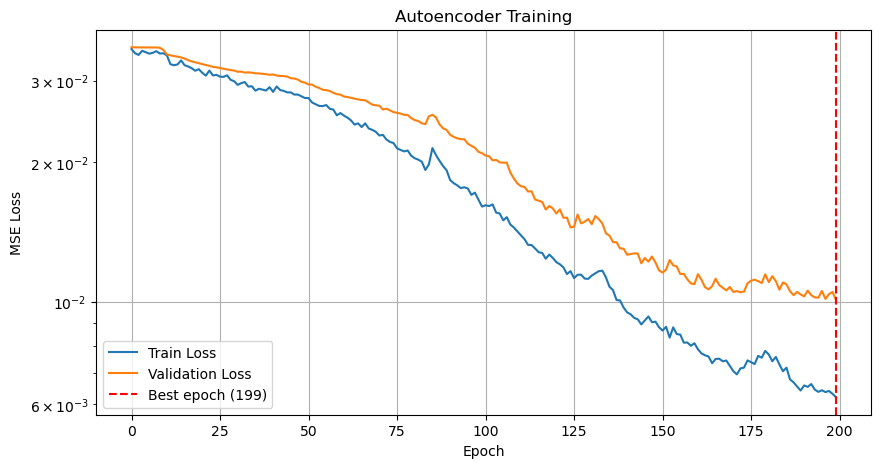

In [10]:
# CELL 8: Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.axvline(best_epoch, color='r', linestyle='--', label=f'Best epoch ({best_epoch})')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training")
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

In [11]:
# CELL 9: Evaluate reconstruction quality
model.eval()
all_recon = []
all_orig = []

with torch.no_grad():
    for data, _ in val_loader:
        data = data.to(device)
        recon, _ = model(data)
        all_recon.append(recon.cpu().numpy())
        all_orig.append(data.cpu().numpy())

orig = np.concatenate(all_orig)
recon = np.concatenate(all_recon)

mse_total = mean_squared_error(orig, recon)
print(f"Final Reconstruction MSE (on validation): {mse_total:.6f}")

# Per-feature MSE (useful to see which columns are hard to reconstruct)
per_feature_mse = np.mean((orig - recon) ** 2, axis=0)
print(f"Mean per-feature MSE: {per_feature_mse.mean():.6f} ± {per_feature_mse.std():.6f}")

Final Reconstruction MSE (on validation): 0.010073
Mean per-feature MSE: 0.010073 ± 0.079077


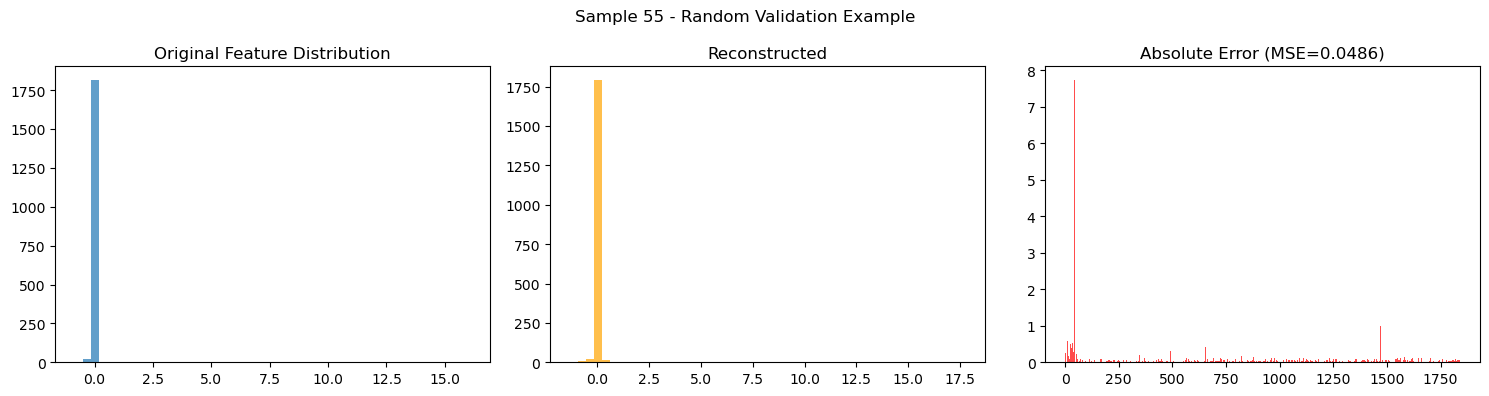

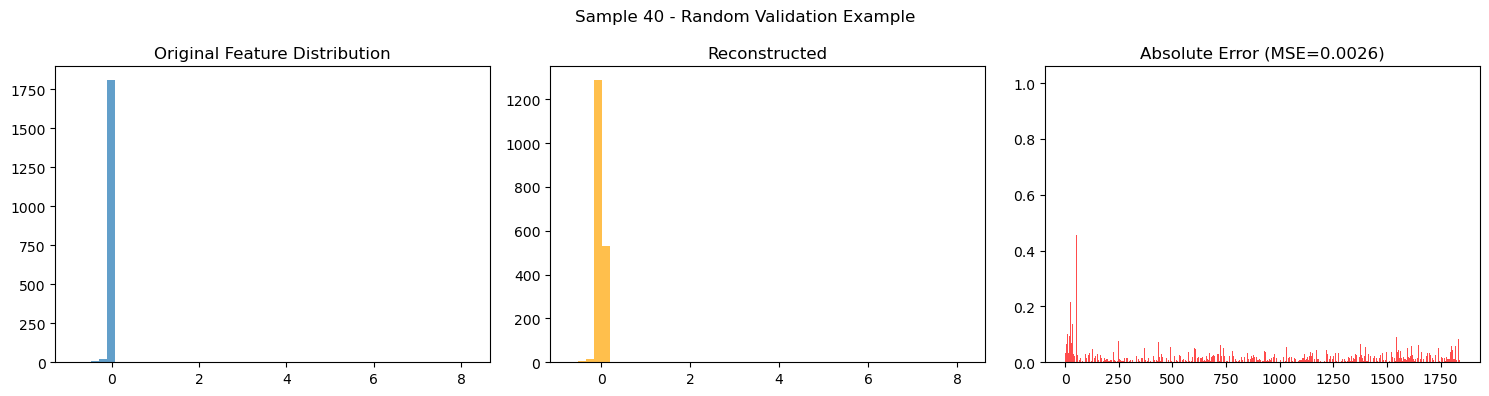

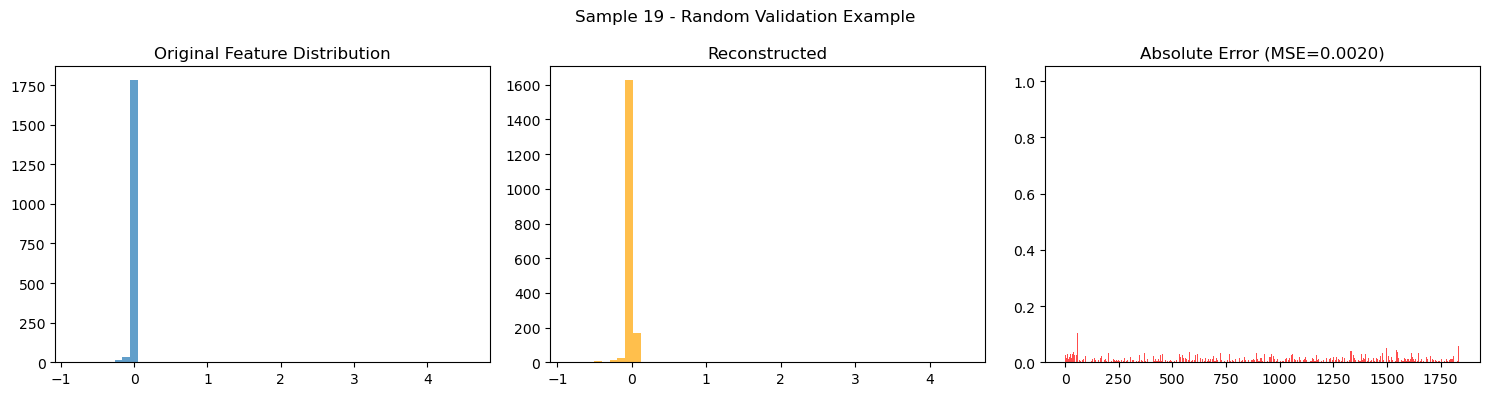

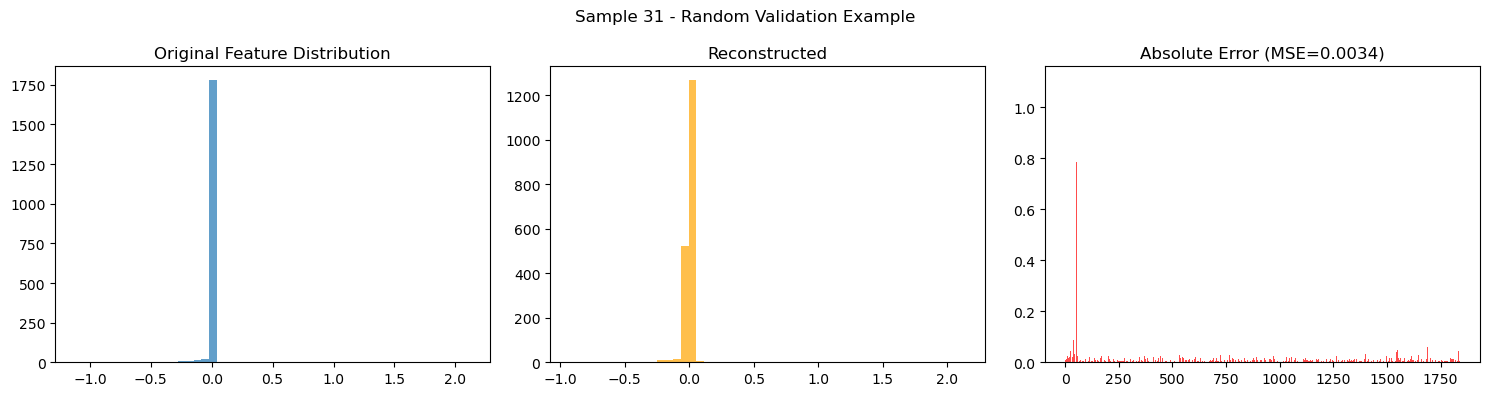

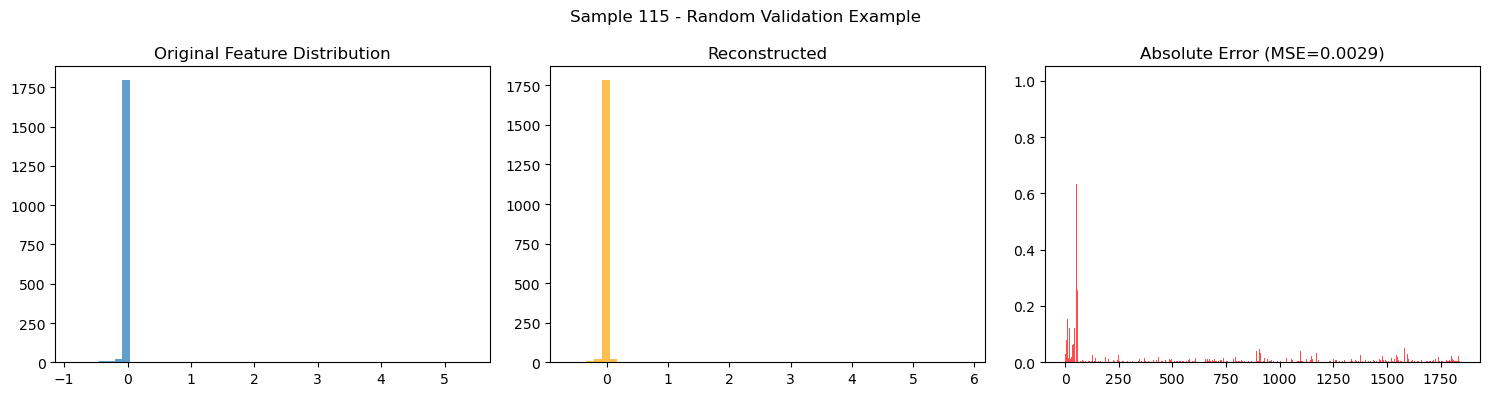

In [12]:
# CELL 10: Visual check - reconstruct a few random samples
n_samples = 5
sample_idx = np.random.choice(len(val_dataset), n_samples, replace=False)

model.eval()
with torch.no_grad():
    for idx in sample_idx:
        x, _ = val_dataset[idx]
        x = x.unsqueeze(0).to(device)
        recon, _ = model(x)
        recon = recon.squeeze(0).cpu().numpy()
        original = x.squeeze(0).cpu().numpy()
        
        # Compute absolute error
        error = np.abs(original - recon)
        
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 3, 1)
        plt.hist(original, bins=50, alpha=0.7, label='Original')
        plt.title("Original Feature Distribution")
        plt.subplot(1, 3, 2)
        plt.hist(recon, bins=50, alpha=0.7, color='orange', label='Reconstructed')
        plt.title("Reconstructed")
        plt.subplot(1, 3, 3)
        plt.bar(range(len(error)), error, alpha=0.7, color='red')
        plt.title(f"Absolute Error (MSE={mean_squared_error(original, recon):.4f})")
        plt.suptitle(f"Sample {idx} - Random Validation Example")
        plt.tight_layout()
        plt.show()

In [13]:
# CELL 11 (Optional): Save the full encoder pipeline + model for later compression
import joblib
import pickle

# Save preprocessor
joblib.dump(preprocessor, "autoencoder_preprocessor.pkl")

# Save only the encoder part for compression later
encoder = model.encoder
torch.save(encoder.state_dict(), "encoder_only.pth")

# Save feature names after one-hot (useful for debugging)
if categorical_cols:
    onehot_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
    all_columns = numeric_cols + list(onehot_columns)
else:
    all_columns = numeric_cols

pd.Series(all_columns).to_csv("autoencoder_feature_names.csv", index=False)

print("Preprocessor and encoder saved! You can now compress new data like this:")
print("""
new_df = pd.read_csv("new_file.csv")
X = preprocessor.transform(new_df)
X_tensor = torch.FloatTensor(X).to(device)
with torch.no_grad():
    compressed = encoder(X_tensor).cpu().numpy()  # shape: (n_samples, encoding_dim)
""")

Preprocessor and encoder saved! You can now compress new data like this:

new_df = pd.read_csv("new_file.csv")
X = preprocessor.transform(new_df)
X_tensor = torch.FloatTensor(X).to(device)
with torch.no_grad():
    compressed = encoder(X_tensor).cpu().numpy()  # shape: (n_samples, encoding_dim)

